Load 'sign' from cached DataFrame to path:  /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/path2tif_sign.csv
Load 'label' from cached DataFrame to path:  /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/path2tif_label.csv
Loading & preparing image data...

Cropping & loading labels by 1st image:
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/input/images_10m/Sentinel_Samara/reg_64_2020_06_90d_comp.b.tif
Files was loaded.
Loading from cache...
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/cropped/labels/landcover23c_v571_2020.Samara.tif
Files was loaded.
Crop labels is done.

Resizing images by 1st label:
Loading from cache...
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/resized/images/reg_64_2020_06_90d_comp.b.tif
Files was loaded.
Loading from cache...
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/resized/images/re

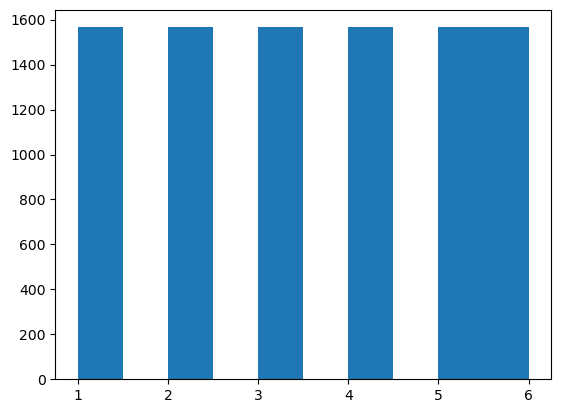

In [ ]:
from utils import *
from prepare_ds import *
from train_ml import *
from create_map import *
from validation import *
from visualisation import *

downgrade_labels = False
force = False

if downgrade_labels:
    src = DEFAULT_PATH["labels"]
    out = DEFAULT_PATH["labels"] + "downgraded/"
    classes_matching = DEFAULT_PATH["labels"] + "classes_matching.csv"
    downgrade_classes(src, out, classes_matching)
    DEFAULT_PATH["labels"] = out

# you can use force=True for re-write all caches.
signs = parse_tifs_from(DEFAULT_PATH["images"], "sign", force=force)
signs = signs.query("type == 'sign'")

labels = parse_tifs_from(DEFAULT_PATH["labels"], "label", force=force)
labels = labels.query("type == 'label'")

year = 2020
only_bands = ["r", "b", "g", "n"]
mask_mode = "homogeneous"
stratify = True
r = 1
homogen_percent = 0.2
percent_assign = 0.2

signs_paths = signs.query(
    f"year == {year} and season == '90d' and band in @only_bands"
).sort_values("band")
signs_paths = signs_paths
labels_paths = labels.query(f"year == {year}")

z_x, z_y, x, y = generate_dataset(
    signs_paths,
    labels_paths,
    percent_assign,
    mask_mode=mask_mode,
    r=r,
    stratify=stratify,
    homogen_percent=homogen_percent,
    force=force,
    verbose=True,
)

uniq_type, uniq_count = np.unique(z_y, return_counts=True)
print(uniq_type, uniq_count)
plt.hist(z_y)
plt.show()

Split X, y -> X_train, y_train...
Start training model...
Selected model / method: RF
Model was trained. Start validate it...

Classification Report:
              precision    recall  f1-score   support

           1       0.67      0.76      0.71       323
           2       0.40      0.49      0.44       290
           3       0.37      0.36      0.37       314
           4       0.82      0.77      0.79       329
           5       0.58      0.59      0.58       307
           6       0.25      0.18      0.21       317

    accuracy                           0.53      1880
   macro avg       0.51      0.53      0.52      1880
weighted avg       0.52      0.53      0.52      1880

Confusion Matrix:
[[247  13  26   6  18  13]
 [ 13 143  52   2  24  56]
 [ 34  72 113   9  32  54]
 [ 24  11  14 252   9  19]
 [ 22  32  33   9 181  30]
 [ 31  84  66  29  50  57]]
Saving model...
Model was saved: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/output/tmp_weights_RF.joblib


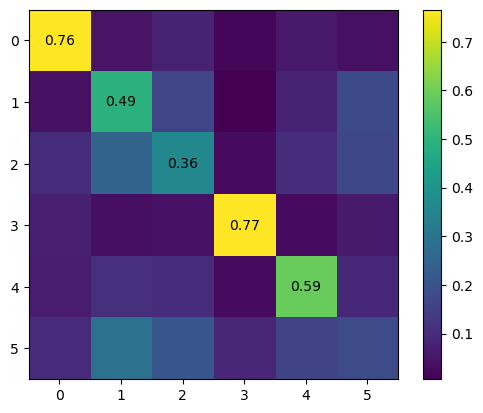

In [16]:
m, m_rep, m_cm, f1 = train_model(z_x, z_y)
plot_confusion(m_cm)

In [17]:
# Mapping by loaded images from path (10m)

only_bands = ["r", "b", "g", "n"]

tiles = DEFAULT_PATH["images"] + "tiles/"
tiles = parse_tifs_from(tiles, typeof="tile")
tiles = tiles.query("band in @only_bands").sort_values("band")["path"]
tiles = tiles.to_list()

loaded_tiles = []
for t in tiles:
    loaded_tiles.append(load_tif(t, only_first=True))

out = f"handle_10m_{mask_mode}_stratify_{stratify}_f1_{f1:.2f}.tif"
out = DEFAULT_PATH["output"] + out
predicted = create_map(loaded_tiles, m, out)

Load 'tile' from cached DataFrame to path:  /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/path2tif_tile.csv
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/input/images_10m/Sentinel_Samara/tiles/comp_s2_90d_b2_l2a_med.frag.0.tif
Files was loaded.
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/input/images_10m/Sentinel_Samara/tiles/comp_s2_90d_b3_l2a_med.frag.0.tif
Files was loaded.
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/input/images_10m/Sentinel_Samara/tiles/comp_s2_90d_b8_l2a_med.frag.0.tif
Files was loaded.
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/input/images_10m/Sentinel_Samara/tiles/comp_s2_90d_b4_l2a_med.frag.0.tif
Files was loaded.
Reshaping tensor-images...
Start create of map...

map size: x = 10980, y = 10980, bands = 4, total px=120560400


Creating map...: 100%|██████████| 58/58 [04:46<00:00,  4.94s/it]


Map is done.
Data saved to /Users/stephenhawking/Coding/ML/low2high_map/src/../data/output/handle_10m_random_stratify_True_f1_0.52.tif


In [5]:
# Module: validation
from validation import *

year = 2020
map = "wc"

# predicted = "/Users/stephenhawking/Coding/ML/low2high_map/src/../data/output/handle_map_10m_0.05.tif"
etalons = DEFAULT_PATH["etalons"]
etalons = parse_tifs_from(etalons, typeof="etalon")
etalons = etalons.query(f"year == {year} and map =='{map}'")["path"].to_list()
r = validate_how_tif(predicted, etalons)
create_diff_map(predicted, etalons[0], "positive")
create_diff_map(predicted, etalons[0], "negative")

Load 'etalon' from cached DataFrame to path:  /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/path2tif_etalon.csv
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/output/handle_10m_secure_stratify_True_f1_0.62.tif
Files was loaded.
Etalons will be loaded from cache.
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/cropped/etalons/r36000.2020.wc.cor.tif
Files was loaded.


/opt/homebrew/anaconda3/envs/Geya/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/Geya/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/Geya/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/output/handle_10m_secure_stratify_True_f1_0.62.tif
Files was loaded.
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/cropped/etalons/r36000.2020.wc.cor.tif
Files was loaded.
(10980, 10980)
Data saved to /Users/stephenhawking/Coding/ML/low2high_map/src/../data/output/positive_handle_10m_secure_stratify_True_f1_0.62.tif
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/output/handle_10m_secure_stratify_True_f1_0.62.tif
Files was loaded.
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/cropped/etalons/r36000.2020.wc.cor.tif
Files was loaded.
(10980, 10980)
Data saved to /Users/stephenhawking/Coding/ML/low2high_map/src/../data/output/negative_handle_10m_secure_stratify_True_f1_0.62.tif
